***RELAX TAKE-HOME CHALLENGE***

***1. Intro*** - understanding the business problem

Relax Inc. wants to know which factors predict whether a user becomes an **adopted user**.  An adopted user is someone who logged in 3 separate days within any 7-day period.  This effectivley measures real engagement.

***2. Load the Datasets***

In [1]:
### - Load Libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
### - Load the Data

users = pd.read_csv('/Users/elliotgaynon/Desktop/Springboard/relax_challenge/Data/takehome_users.csv', encoding='latin-1')

engagement = pd.read_csv('/Users/elliotgaynon/Desktop/Springboard/relax_challenge/Data/takehome_user_engagement.csv')

***2. Explore the Data***

Inspect dtypes, check for missing values, look for useful features.

In [5]:
### - Explore Data - Users

users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


Need to convert 'creation_time' to datetime.  Also see missing values for 'last_session_creation_time' and 'invited_by_user_id'.  The latter of which as 6417, which means that more than half of users are invited.

In [4]:
### - Explore Data - Engagement

engagement.info()
engagement.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


Need to convert 'time_stamp' to date time. No missing values.

In [6]:
### - Convert to datetime

users['creation_time'] = pd.to_datetime(users['creation_time'])

engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [9]:
### - confirm datetime

users['creation_time'].info()
engagement['time_stamp'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 12000 entries, 0 to 11999
Series name: creation_time
Non-Null Count  Dtype         
--------------  -----         
12000 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 93.9 KB
<class 'pandas.core.series.Series'>
RangeIndex: 207917 entries, 0 to 207916
Series name: time_stamp
Non-Null Count   Dtype         
--------------   -----         
207917 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.6 MB


In [10]:
### - Sanity checks

### - how many unique users signed in?

engagement['user_id'].nunique()

8823

8,823 users actually used the product out of 12,000 total users. In other words approx 74 % of users tried the project after signing up. 3,177 users never came back after signing up.

In [11]:
### Check signup methods

users['creation_source'].value_counts()

creation_source
ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: count, dtype: int64

Most users come from invitations.  This means that growth is mostly due to collaboration or team invites.  Adoption often correlates with network effects.  An early hypothesis that emerges is users invited to use the product may be more likely to become adopted users.

***3. Identify Adopted Users***

In [15]:
engagement = engagement.sort_values(['user_id', 'time_stamp'])

adopted_users = set()

for user_id, group in engagement.groupby('user_id'):
    logins = group['time_stamp']

    for i in range(len(logins) - 2):
        if (logins.iloc[i + 2] - logins.iloc[i]).days <= 7:
            adopted_users.add(user_id)
            break

In [16]:
### - Create adopted user column
users['adopted_user'] = users['object_id'].isin(adopted_users).astype(int)

In [18]:
### - explore column

users['adopted_user'].value_counts()

adopted_user
0    10344
1     1656
Name: count, dtype: int64

I found 1,656 adopted users and 10,344 non-adopted users.

In [19]:
users['adopted_user'].mean()

np.float64(0.138)

The adoption rate is 13.8 percent.  This means that many people sign up, but much fewer reach meaningful usage and adoption.

***4. Analysis***


I want to explore what factors contribute to future user adoption.  In order to do this, I will test each feature against adoption.

In [20]:
### - Adoption by Creation Source

adoption_by_source = (
    users.groupby('creation_source')['adopted_user']
    .mean()
    .sort_values(ascending=False)
)

adoption_by_source

creation_source
SIGNUP_GOOGLE_AUTH    0.172563
GUEST_INVITE          0.170596
SIGNUP                0.144705
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
Name: adopted_user, dtype: float64

Google sign-ups have the highest adoption rate.  This suggests that low-friction signup methods may improve engagement.  Also, guest invitations perform very well.  This suggests that network effects matter.  Lastly, we see that personal projects adopt the least with less than 10 percent adopting.  This means that users working alone are less engaged.  This slightly goes against my hypothesis, which was users who will be invited will have the highest adoption rate.  Instead we see Google Singup as having the best outcome for user adoption.  Potential Product actions from this would be to promote google sign ups, encourage team invitations, or improve the experience for solo users.

In [21]:
### - Adoption by Invitation

users['was_invited'] = users['invited_by_user_id'].notnull().astype(int)

users.groupby('was_invited')['adopted_user'].mean()

was_invited
0    0.127709
1    0.146953
Name: adopted_user, dtype: float64

Invitations increase adoption, but only slightly.  Less than 2 percent.

In [23]:
### - Adoption by Marketing Emails

users.groupby('opted_in_to_mailing_list')['adopted_user'].mean()

opted_in_to_mailing_list
0    0.136243
1    0.143287
Name: adopted_user, dtype: float64

In [24]:
users.groupby('enabled_for_marketing_drip')['adopted_user'].mean()

enabled_for_marketing_drip
0    0.137049
1    0.143415
Name: adopted_user, dtype: float64

Marketing campaigns appear to have a minimally positive effect on adoption.  This shows that emails alone are not a strong driver of sustained product engagement.

***Conclusion***

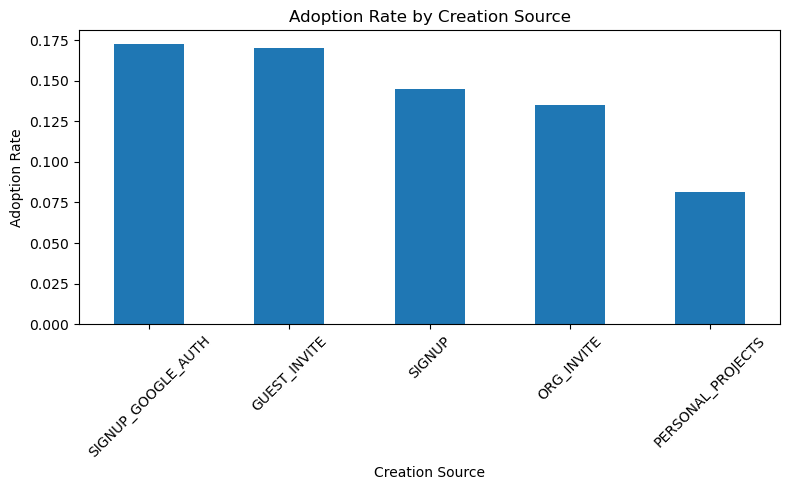

In [26]:
### - Adoption Rate by Creation Source - Best Predictor - Google Signup

import matplotlib.pyplot as plt

adoption_by_source = (
    users.groupby('creation_source')['adopted_user']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
adoption_by_source.plot(kind='bar')

plt.title("Adoption Rate by Creation Source")
plt.ylabel("Adoption Rate")
plt.xlabel("Creation Source")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Overall, adoption is relatively low.  Only 13.8 percent of users became adopted users.  This reveals that many users sign up ,but do not develop consistent usage.

Sign-up method appears to be one of the strongest predictors of adoption.  Google sign up appears to have the highest adoption of users.  Guest invite is the second most.  Personal project users has the lowest adoption.  This suggests that collaboration and convenient log-in drive engagement.

From the data, we also saw that invitations helped, but only modestly.  Like invites, marketing had a limited impact.  Overall, this suggests that engagement is driven more by product use cases than marketing.

To improve adoption, collaborative onboarding experiences should be prioritized. Team invites should be encouraged, as well as promoting seamless signup methods like Google.